In [19]:
import os
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import pandas as pd
from google.colab import drive
from google.colab import files
import random
import torch.optim as optim
import albumentations as A
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader
import torchvision
import torch
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import copy
import torch.nn as nn
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
import os
from sklearn.model_selection import train_test_split
from pathlib import Path


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
p = '/content/drive/MyDrive/DL'
os.listdir(p)

['dl-2025-competition-1.zip', 'dl-2025-competition-1', '__MACOSX']

In [4]:
path_df ='/content/drive/MyDrive/DL/dl-2025-competition-1.zip'

In [5]:
#with zipfile.ZipFile(path_df, 'r') as zr:
#    zr.extractall('/content/drive/MyDrive/DL/')

In [6]:
data_dir = '/content/drive/MyDrive/DL/dl-2025-competition-1/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


classes = os.listdir(train_dir)
num_classes = len(classes)

train_counts = {}
for cls in classes:
    train_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

count_df = pd.DataFrame({
    'Class': classes,
    'Train Samples': [train_counts[cls] for cls in classes]
})

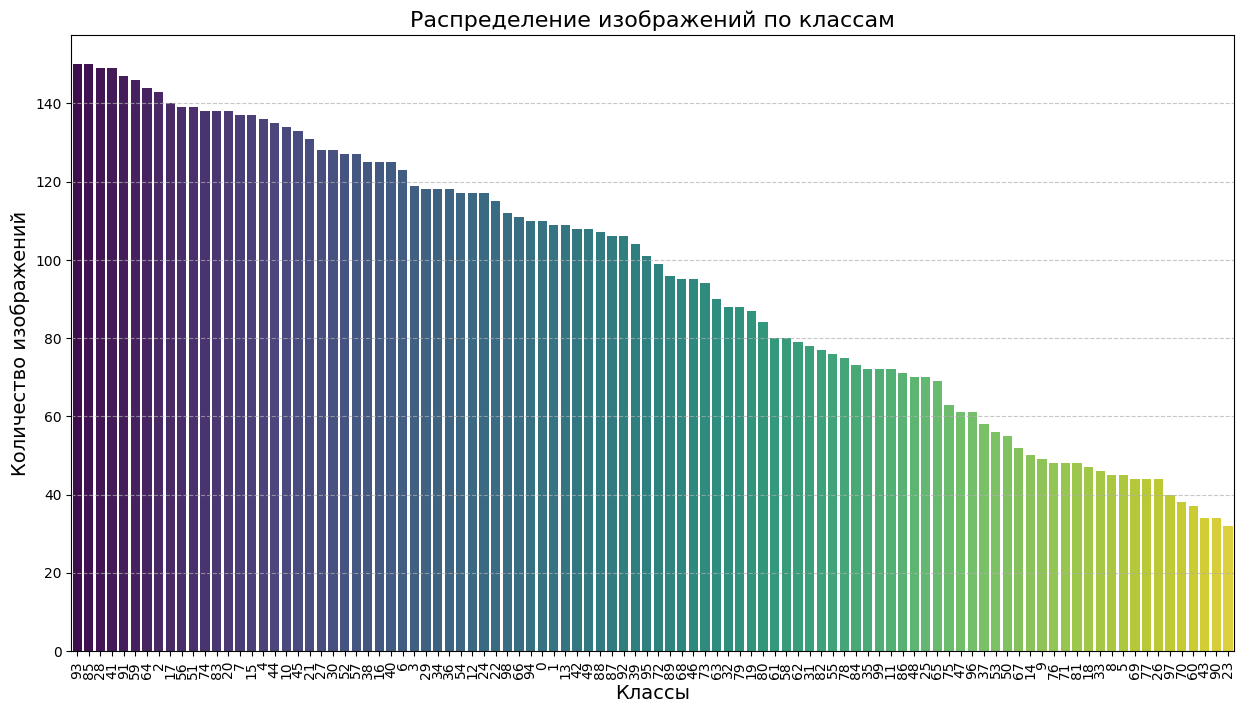

In [7]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=count_df.sort_values('Train Samples', ascending=False),
                 x='Class',
                 y='Train Samples',
    hue='Class', palette='viridis')
plt.title('Распределение изображений по классам', fontsize=16)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Количество изображений', fontsize=14)
plt.xticks(rotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Видно, что есть дисбаланс класссов. Примерно четверть классов имеют в 3-4 раза меньше сэмплов, чем четвертый квартиль.

In [8]:
count_df.describe()

,Train Samples
count,100.000000
mean,95.100000
std,35.439093
min,32.000000
25%,67.500000
50%,100.000000
75%,125.500000
max,150.000000


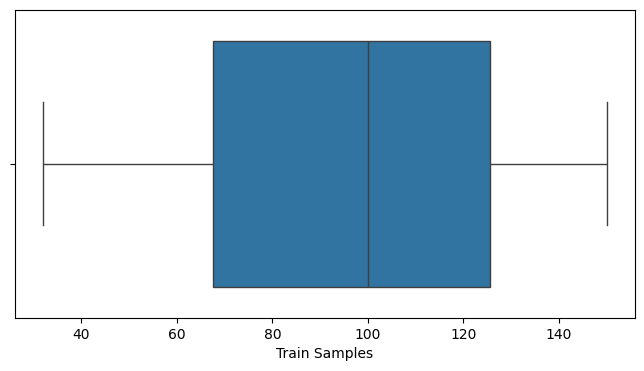

In [9]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=count_df['Train Samples'])
plt.show()

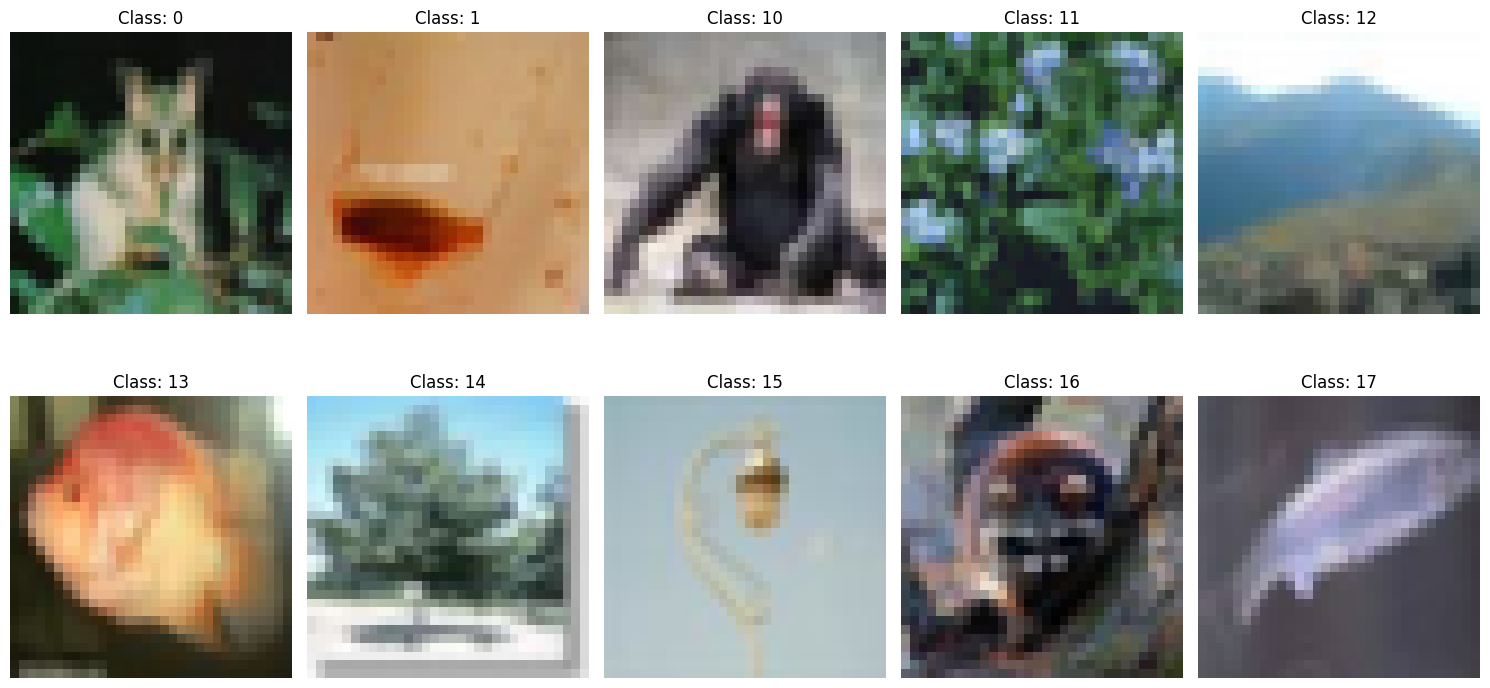

In [10]:
classes_img = sorted(os.listdir(train_dir))[:10]



plt.figure(figsize=(15, 8))
for i, cls in enumerate(classes_img):
    class_images = os.listdir(os.path.join(train_dir, cls))
    img_name = random.choice(class_images)
    img_path = os.path.join(train_dir, cls, img_name)

    try:
        img = Image.open(img_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f'Class: {cls}')
        plt.axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.show()

In [11]:
sizes = []
for cls in classes[:10]:
    for img_name in os.listdir(os.path.join(train_dir, cls)):
        img_path = os.path.join(train_dir, cls, img_name)
        sizes.append(Image.open(img_path).size)


sizes = np.array(sizes)


print(f"Average width: {np.mean(sizes[:, 0]):.1f} ± {np.std(sizes[:, 0]):.1f}")
print(f"Average height: {np.mean(sizes[:, 1]):.1f} ± {np.std(sizes[:, 1]):.1f}")
print(f"Min size: {sizes.min(axis=0)}")
print(f"Max size: {sizes.max(axis=0)}")


Average width: 32.0 ± 0.0
Average height: 32.0 ± 0.0
Min size: [32 32]
Max size: [32 32]


Все изображения одного размера. Этот размер довольно мал

In [12]:
# def compute_mean_std_fast(dataset_path, max_samples=10000):
#     pixel_sum = np.zeros(3)
#     pixel_sq_sum = np.zeros(3)
#     count = 0

#     class_folders = os.listdir(dataset_path)
#     np.random.shuffle(class_folders)

#     for class_folder in tqdm(class_folders, desc="Processing classes"):
#         if count >= max_samples:
#             break

#         class_path = os.path.join(dataset_path, class_folder)
#         if not os.path.isdir(class_path):
#             continue

#         img_names = os.listdir(class_path)
#         np.random.shuffle(img_names)

#         for img_name in img_names:
#             if count >= max_samples:
#                 break

#             img_path = os.path.join(class_path, img_name)
#             try:
#                 img = Image.open(img_path).convert('RGB')
#                 img_array = np.array(img) / 255.0
#                 pixel_sum += img_array.mean(axis=(0, 1))
#                 pixel_sq_sum += (img_array**2).mean(axis=(0, 1))
#                 count += 1
#             except:
#                 continue

#     mean = pixel_sum / count
#     std = np.sqrt(pixel_sq_sum / count - mean**2)

#     return mean, std

# compute_mean_std_fast(train_dir)

(array([0.50691125, 0.48691937, 0.44028778]),
 array([0.2668507 , 0.25536751, 0.27503409]))


In [13]:
mean = [0.50691125, 0.48691937, 0.44028778]
std = [0.2668507, 0.25536751, 0.27503409]

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

In [15]:
train_dataset = CustomDataset(train_dir, transform=train_transform)


batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

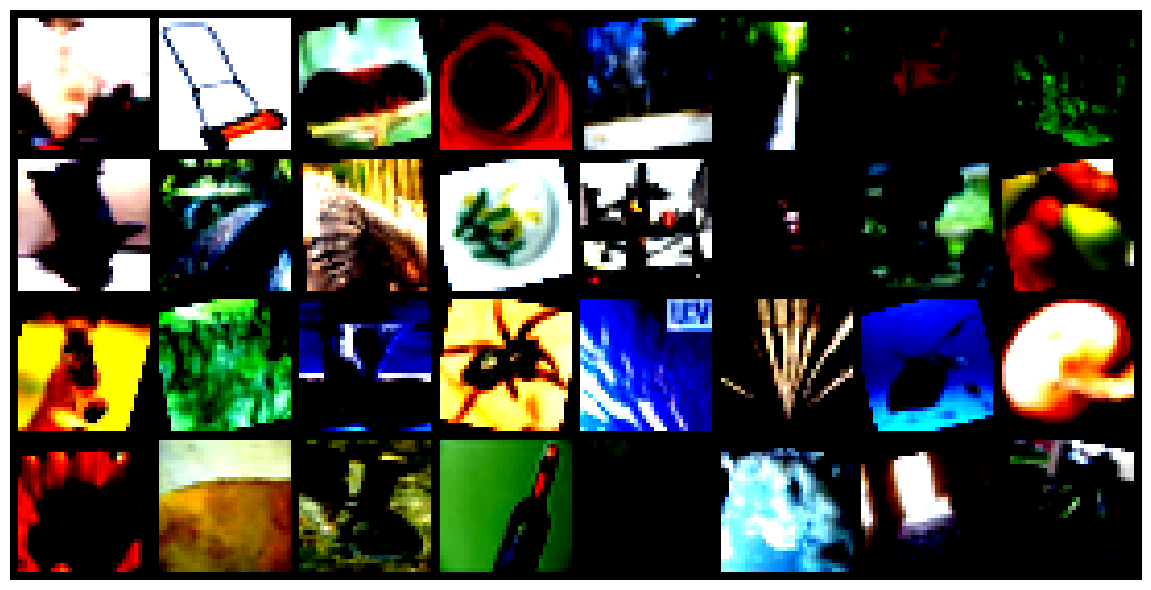

In [16]:
def denormalize_image(tensor):
    return tensor.clone()

def show_batch_images(dataloader, num_images=32, nrow=8, figsize=(12, 6)):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    img_grid = torchvision.utils.make_grid(
        denormalize_image(images),
        nrow=nrow,
        padding=2,
        normalize=False
    )
    plt.figure(figsize=figsize)
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


show_batch_images(train_loader)

In [17]:
class AdvancedDataset(Dataset):
    def __init__(self, samples, transform=None, upscale=False, cache=True):
        """
        Args:
            samples: список кортежей (путь_к_изображению, метка)
            transform: albumentations трансформации
            upscale: увеличивать ли изображения
            cache: кэшировать ли изображения в памяти
        """
        self.samples = samples
        self.transform = transform
        self.upscale = upscale
        self.cache = cache
        self.image_cache = {}

        self.classes = sorted(list(set([label for _, label in samples])))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def _load_image(self, path):
        if self.cache and path in self.image_cache:
            return self.image_cache[path]

        image = Image.open(path).convert('RGB')
        if self.upscale:
            image = image.resize((config['image_size'], config['image_size']), Image.BICUBIC)

        image = np.array(image)
        if self.cache:
            self.image_cache[path] = image
        return image

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self._load_image(path)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, torch.tensor(label, dtype=torch.long)

In [18]:
def split_image_dataset(data_dir, test_size=0.2, valid_extensions=('.jpg', '.jpeg', '.png')):
    samples = []
    labels = []

    for class_dir in Path(data_dir).iterdir():
        if not class_dir.is_dir():
            continue

        try:
            label = int(class_dir.name)
        except ValueError:
            continue

        for img_file in class_dir.glob('*'):
            if img_file.suffix.lower() in valid_extensions:
                samples.append((str(img_file), label))
                labels.append(label)


    train_samples, val_samples = train_test_split(
        samples,
        test_size=test_size,
        stratify=labels
    )

    return train_samples, val_samples

train_samples, val_samples = split_image_dataset(train_dir)

In [20]:

config = {
    'batch_size': 128,
    'num_workers': 2,
    'lr': 0.001,
    'epochs': 5,
    'patience': 3,
    'warmup_epochs': 1,
    'image_size': 64
}

basic_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

advanced_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [21]:
train_basic = AdvancedDataset(train_samples, transform=basic_transform)
train_advanced = AdvancedDataset(train_samples, transform=advanced_transform)
train_tl = AdvancedDataset(train_samples, transform=advanced_transform, upscale=True)

val_ds = AdvancedDataset(val_samples, transform=basic_transform)
val_tl = AdvancedDataset(val_samples, transform=basic_transform, upscale=True)


train_basic_loader = DataLoader(train_basic, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
train_advanced_loader = DataLoader(train_advanced, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
train_tl_loader = DataLoader(train_tl, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])

val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])
val_tl_loader = DataLoader(val_tl, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

In [22]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def create_resnet(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


def train_model(model, train_loader, val_loader, config, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch+1}/{config['epochs']} - {model_name}")


        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total


        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)


        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")

    plot_history(history, model_name)
    return model, history

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Базовая CNN с базовыми аугментациями**

In [ ]:
results = {}
model = BasicCNN(num_classes)
history = train_model(model, train_basic_loader, val_loader,config,"BasicCNN_basic_aug")
results['BasicCNN_basic_aug'] = history


Epoch 1/5 - BasicCNN_basic_aug


Training:   0%|          | 0/60 [00:00<?, ?it/s]

# **2. Базовая CNN с продвинутыми аугментациями**

In [ ]:
model = BasicCNN(num_classes)
history = train_model(model, train_advanced_loader, val_loader,config, "BasicCNN_advanced_aug")
results['BasicCNN_advanced_aug'] = history

# **3. ResNet с апскейлингом и базовыми аугментациями**

In [ ]:
model = create_resnet(num_classes)
history = train_model(model, train_basic_loader, val_tl_loader, config, "ResNet_basic_aug")
results['ResNet_basic_aug'] = history

# **4. ResNet с апскейлингом и продвинутыми аугментациями (скор на кагле)**

In [ ]:
model_4 = create_resnet(num_classes)
history = train_model(model_4, train_tl_loader, val_tl_loader, config, "ResNet_advanced_aug")
results['ResNet_advanced_aug'] = history

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform):
        self.paths = sorted([
            os.path.join(test_dir, fname)
            for fname in os.listdir(test_dir)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                img = np.array(img)
                img = self.transform(image=img)["image"]
            return img, os.path.basename(img_path)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            dummy_img = torch.zeros(3, *self.transform.size, dtype=torch.float32)
            return dummy_img, os.path.basename(img_path)

    def __len__(self):
        return len(self.paths)

test_dataset = TestDataset(test_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = results['ResNet_advanced_aug'][0]

In [ ]:
model.load_state_dict(torch.load("best_ResNet_advanced_aug.pth"))
model.to(device)
model.eval()

predictions = []
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        for fname, label in zip(filenames, predicted.cpu().numpy()):
            img_id = int(os.path.splitext(fname)[0])
            predictions.append((img_id, label))


predictions.sort(key=lambda x: x[0])

df = pd.DataFrame(predictions, columns=["id", "target"])
df.to_csv("submission.csv", index=False)

In [ ]:
from google.colab import files
files.download("submission.csv")